# Example: CitiBike data

This is adapted from [this ipython notebook](http://nbviewer.ipython.org/gist/kjordahl/7129098) by geopandas creator Kelsy Jordahl.  What's different is:

- this notebook is written to work with python 3.4
- I've added new cells along the way to explore the data and geopandas functionality in more detail, adding documentation/explanations along the way.

In [1]:
%matplotlib inline
import requests
import json
from pyproj import Proj
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0)
#%config InlineBackend.figure_format = 'svg'

NYC borough boundaries downloaded from [Bytes of the Big Apple](http://www.nyc.gov/html/dcp/download/bytes/nybb_13a.zip)

I am re-indexing on the Borocode (e.g. Manhattan=1, Brooklyn = 3)

In [3]:
shpfile = r'data\nybb.shp'
temp = GeoDataFrame.from_file(shpfile)
boros = temp.set_index('BoroCode')
boros.sort()

BoroName    Shape_Area     Shape_Leng  \
BoroCode                                               
1             Manhattan  6.364467e+08  358408.460709   
2                 Bronx  1.186973e+09  464400.198868   
3              Brooklyn  1.937597e+09  741185.900596   
4                Queens  3.045168e+09  897040.298576   
5         Staten Island  1.623827e+09  330466.075042   

                                                   geometry  
BoroCode                                                     
1         (POLYGON ((981219.0557861328 188655.3157958984...  
2         (POLYGON ((1012821.805786133 229228.2645874023...  
3         (POLYGON ((1021176.479003906 151374.7969970703...  
4         (POLYGON ((1029606.076599121 156073.8142089844...  
5         (POLYGON ((970217.0223999023 145643.3322143555...

In [4]:
boros.columns

Index(['BoroName', 'Shape_Area', 'Shape_Leng', 'geometry'], dtype='object')

Plot Brooklyn

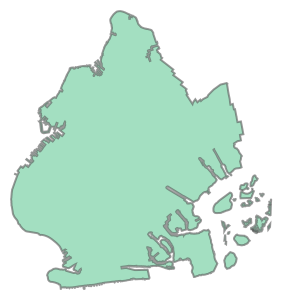

In [5]:
boros.geometry[3]

Load real time bike station data from [CitiBike](http://citibikenyc.com) json API:

In [6]:
try:
    url = 'http://citibikenyc.com/stations/json'
    f = requests.get(url)
    c = f.json()   
    print("Loaded Citibike data from online source")
except:
    print("Reading cached data")
    c = json.load(open('citibike.json'))
else:
    json.dump(c, open('citibike.json', 'w'))
    
df = GeoDataFrame(c['stationBeanList'])

Loaded Citibike data from online source


In [7]:
df.columns

Index(['altitude', 'availableBikes', 'availableDocks', 'city', 'id',
       'landMark', 'lastCommunicationTime', 'latitude', 'location',
       'longitude', 'postalCode', 'stAddress1', 'stAddress2', 'stationName',
       'statusKey', 'statusValue', 'testStation', 'totalDocks'],
      dtype='object')

####Prepare data for mapping of citibike stations
- Note there is no geometry information in the dataframe yet, so let's build it.
Shapely is a Python wrapper for GEOS for algebraic manipulation of geometry.
A shapely.geometry.Point has an interior set of exactly one point.
- We add a geometry column to the geodataframe and then choose a projection system (boro data is in feet)
- df.geometry.total_bounds Returns a tuple containing minx, miny, maxx, maxy values for the bounds of the series as a whole
-- all common spatial reference systems have a recognized integer ID called an EPSG code, a simple way to identify a projection.

In [8]:
s = GeoSeries([Point(x, y) for x, y in zip(df['longitude'], df['latitude'])])
df['geometry'] = s
df.crs = {'init': 'epsg:4326', 'no_defs': True}
df.geometry.total_bounds

(-74.01713445, 40.680342422999999, -73.950047975900006, 40.771521999999997)

In [9]:
print(df.geometry.head())

0    POINT (-73.99392888 40.76727216)
1    POINT (-74.00666661 40.71911552)
2    POINT (-74.00016545 40.71117416)
3    POINT (-73.97632328 40.68382604)
4    POINT (-74.00149746 40.74177603)
Name: geometry, dtype: object


To plot these points on the boros map we need to transform the geometries in the df.geometry column to the coordinate reference system use from the boros map, contained in boros.crs 

In [10]:
boros.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [11]:
df.to_crs(boros.crs, inplace=True)
df.geometry.total_bounds

(979499.5403944857, 187146.60522234702, 998104.68869063177, 220363.19830252684)

In [12]:
print(df.geometry.head())

0    POINT (985931.7065028986 218814.7571059909)
1    POINT (982402.0068864172 201269.7703469703)
2    POINT (984204.1315763244 198376.4207269302)
3    POINT (990816.6931712306 188413.5778061197)
4    POINT (983835.0432398723 209525.6347344019)
Name: geometry, dtype: object


Simple plot of bike stations

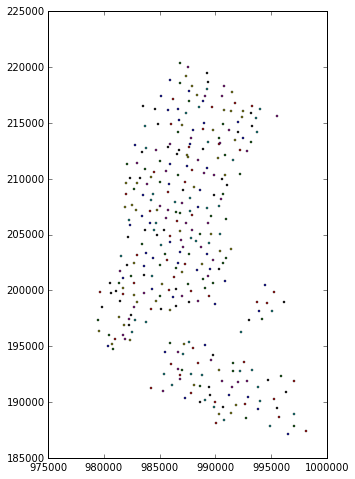

In [13]:
df.plot()

Let's now count the bike stations, bikes, and docks in each boro
- df.geometry.within(manhattan) returns a Series of dtype('bool') with value True if each Point in the df.geometry intersects only with the interior of the geometry that defines manhattan (not its boundary or exterior). In short in_mn will be all points in manhattan.
- Next we sum all availableBikes in Manhattan and Brooklyn

In [14]:
manhattan = boros.geometry[3]
brooklyn = boros.geometry[1]
in_mn = df.geometry.within(manhattan)
in_bk = df.geometry.within(brooklyn)
print( sum(in_mn), 'stations in Manhattan')
print( sum(in_bk), 'stations in Brooklyn')
print()
print( sum(df['availableBikes'][in_mn]), 'available bikes in Manhattan')
print( sum(df['availableBikes'][in_bk]), 'available bikes in Brooklyn')
print()
print( sum(df['availableDocks'][in_mn]), 'available docks in Manhattan')
print( sum(df['availableDocks'][in_bk]), 'available docks in Brooklyn')

77 stations in Manhattan
252 stations in Brooklyn

828 available bikes in Manhattan
3411 available bikes in Brooklyn

1266 available docks in Manhattan
5313 available docks in Brooklyn


####Now some fancier stuff
- .unary_union returns a geometry containing the union of all geometries in the GeoSeries.  A 'multipoint'

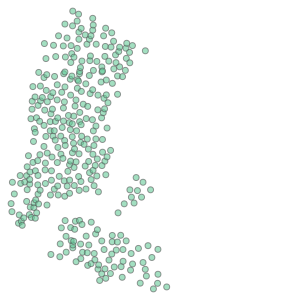

In [15]:
mp = df.geometry.unary_union
mp

Let's plot a buffer around the stations (I'm not following exactly what's going on)

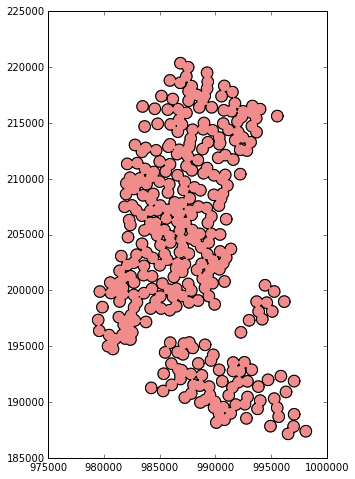

In [34]:
block = 260
geoms = [mp]
contour = mp.buffer(2 * block)
geoms.append(contour)
zones = GeoSeries(geoms)
zones.plot()

Here we plot buffers inside wider bufers

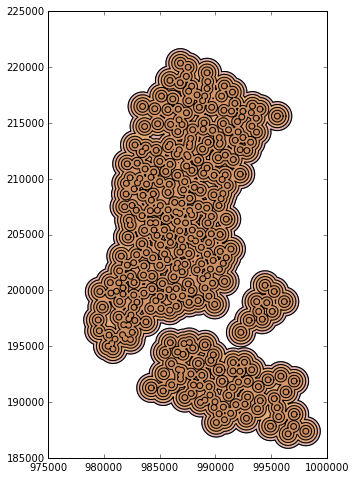

In [39]:
block = 260
geoms = [mp]
for r in range(1, 6):
    contour = mp.buffer(r * block)
    geoms.append(contour)
zones = GeoSeries(geoms)
zones.plot()

Plot this again but inside map boundaries

In [40]:
nyc = boros.geometry.unary_union
nyc

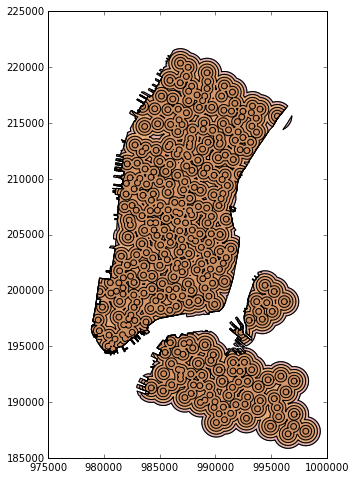

In [41]:
zones.intersection(nyc).plot('Set1')

Load cleaned version of MTA subway station locations from [Steven Romalewski's Spatiality blog](http://spatialityblog.com/2010/07/08/mta-gis-data-update/):

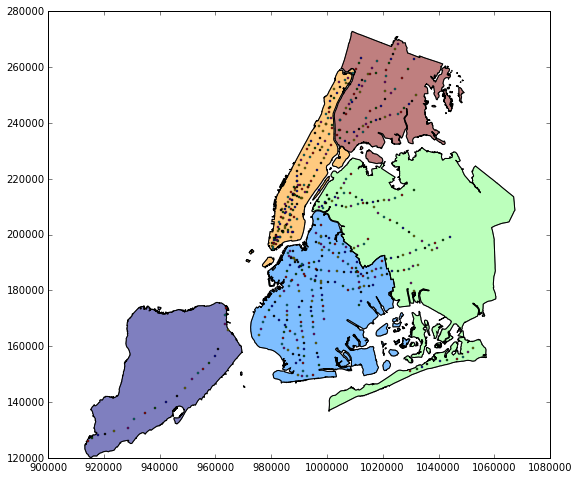

In [44]:
subways = GeoDataFrame.from_file(r'data\nyctsubwaystops_100627_curcleaned.shp')
subways.to_crs(boros.crs, inplace=True)
boros.plot()
subways.plot()

In [46]:
subways['bike_distance'] = subways.geometry.distance(mp)

In [47]:
subways.sort('bike_distance', inplace=True)

#### What subway stations are less than 1 block from a CitiBike station?

In [48]:
len(subways[subways['bike_distance'] < 260])

38

In [51]:
subways.columns

Index(['LOCATION_T', 'NAME_CUR', 'PARENT_STA', 'Routes_ALL', 'Routes_OFF',
       'Routes_WKD', 'STOP_CODE', 'STOP_DESC', 'STOP_ID', 'STOP_LAT',
       'STOP_LON', 'STOP_NAME', 'STOP_URL', 'ZONE_ID', 'geometry',
       'bike_distance'],
      dtype='object')

In [59]:
subways[subways['bike_distance'] < 260][['NAME_CUR','Routes_ALL']]

NAME_CUR   Routes_ALL
144                  51TH STREET     4, 6, 6X
64                 FULTON STREET         2, 3
344               CLASSON AVENUE            G
29                   14TH STREET      1, 2, 3
25            34TH ST - PENN STA      1, 2, 3
264    WEST 4 ST - WASHINGTON SQ   B, D, F, M
202      WEST 4 ST - UPPER LEVEL      A, C, E
379     UNION SQUARE - 14 STREET            L
468            FRANKLIN - FULTON           FS
33               FRANKLIN STREET         1, 2
66                  CLARK STREET         2, 3
150            ASTOR PL - 8TH ST     4, 6, 6X
453              LAWRENCE STREET         N, R
146                  33RD STREET     4, 6, 6X
110                BOWLING GREEN         4, 5
65             WALL - WILLIAM ST         2, 3
286           WORLD TRADE CENTER            E
153                 CANAL STREET     4, 6, 6X
440         TIMES SQUARE - 42 ST      N, Q, R
152                SPRING STREET     4, 6, 6X
154  BROOKLYN BRIDGE - CITY HALL  4, 5, 6, 6X
38          SOUTH FERRY TERMINAL            1
437           5TH AVENUE - 59 ST      N, Q, R
447        CANAL STREET / TUNNEL         N, R
455    PACIFIC STREET - ATLANTIC      D, N, R
451   WHITEHALL ST - SOUTH FERRY         N, R
30      CHRISTOPHER - SHERIDAN S         1, 2
233                  57TH STREET            F
299                EAST BROADWAY            F
149       14TH STREET - UNION SQ  4, 5, 6, 6X
213              NOSTRAND AVENUE         A, C
32                  CANAL STREET         1, 2
145        GRAND CENTRAL - 42 ST  4, 5, 6, 6X
23                   50TH STREET         1, 2
37          SOUTH FERRY - A LOOP         None
441      34TH STREET - HERALD SQ      N, Q, R
26                   28TH STREET         1, 2
24            42ND ST - TIMES SQ      1, 2, 3